In [30]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

Exercises:
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [31]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
chars = ["."] + sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
block_size = 3
vocab_size = len(itos)
embedding_size = 10
hidden_size = 200

In [32]:
def build_dataset(words, block_size):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)


def split_dataset(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    train = words[:n1]
    dev = words[n1:n2]
    test = words[n2:]
    X_train, y_train = build_dataset(train, block_size)
    X_dev, y_dev = build_dataset(dev, block_size)
    X_test, y_test = build_dataset(test, block_size)
    return X_train, y_train, X_dev, y_dev, X_test, y_test


X_train, y_train, X_dev, y_dev, X_test, y_test = split_dataset(words)

In [33]:
gain = 5 / 3
fan_in = block_size * embedding_size
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((embedding_size * block_size, hidden_size), generator=g) * 0.0
b1 = torch.randn(hidden_size, generator=g) * 0.0
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0
b2 = torch.randn(vocab_size, generator=g) * 0


parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [34]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.arange(0, batch_size)
    Xb, yb = X_train[ix], y_train[ix]
    emb = C[Xb]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    h.retain_grad()
    if i % 10000 == 0:
        print(h.grad)
        print(yb)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    if i % 10000 == 0:
        print(f"{i} / {max_steps}, loss: {loss.item()}")

    lossi.append(loss.log10().item())

None
tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15, 14,  4, 18,  5,  0, 24,  1, 22,
         9,  5, 14,  0, 10, 15, 18,  9,  0, 10, 21,  1, 14, 12])
0 / 200000, loss: 3.295837163925171
None
tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15, 14,  4, 18,  5,  0, 24,  1, 22,
         9,  5, 14,  0, 10, 15, 18,  9,  0, 10, 21,  1, 14, 12])
10000 / 200000, loss: 2.659883975982666
None
tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15, 14,  4, 18,  5,  0, 24,  1, 22,
         9,  5, 14,  0, 10, 15, 18,  9,  0, 10, 21,  1, 14, 12])
20000 / 200000, loss: 2.6565420627593994
None
tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15, 14,  4, 18,  5,  0, 24,  1, 22,
         9,  5, 14,  0, 10, 15, 18,  9,  0, 10, 21,  1, 14, 12])
30000 / 200000, loss: 2.655435562133789
None
tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15, 14,  4, 18,  5,  0, 24,  1, 22,
         9,  5, 14,  0, 10, 15, 18,  9,  0, 10, 21,  1, 14, 12])
40000 / 200000, loss: 2.6548850536346436
None
tensor([25, 21,  8,  5, 14,  7,  0,  4,  9, 15,

KeyboardInterrupt: 

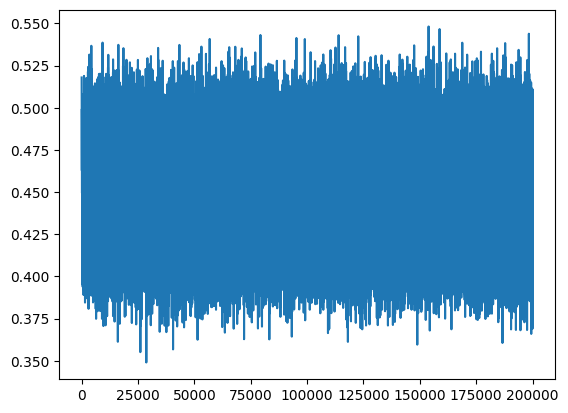

In [ ]:
plt.plot(lossi)

In [ ]:
# check if all the elements in W1 are zero
print(torch.all(W1 == 0))
print(torch.all(b1 == 0))
print(torch.all(W2 == 0))
print(torch.all(b2 == 0))

tensor(True)
tensor(True)
tensor(True)
tensor(False)


In [ ]:
print(torch.all(W1.grad == 0))
print(torch.all(b1.grad == 0))
print(torch.all(W2.grad == 0))
print(torch.all(b2.grad == 0))

tensor(True)
tensor(True)
tensor(True)
tensor(False)


In [ ]:
print(torch.all(h.grad == 0))
print(torch.all(hpreact.grad == 0))
print(torch.all(logits.grad == 0))

tensor(True)
tensor(True)
tensor(False)


In [ ]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.8226542472839355
val 2.821113109588623


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

prn.
ehqz.
eeiblieninato.
ralaeaozttd.
a.
yliayryaajuee.
eimazcakmemli.
.
raatyravaeaoareoiymyheusthse.
.
r.
f.
ethladan.
sdm.
asaanaae.
hensiztsazhaisylnai.
.
.
iuaaoenaardl.
i.
